In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannotations.Annotator as statannotator
import statsmodels.api as sm
import sys

# Appending python modules so we can run simulations
sys.path.append('../python')

import json_utilities
import model_utilities
from matplotlib.pyplot import figure
from pymunk.vec2d import Vec2d
from scipy import stats

pygame 2.1.2 (SDL 2.0.18, Python 3.10.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Are we saving figures?
saving_figures = False
figure_dir = '../paper/figures/src'

In [31]:
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=2,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
    },
)


In [21]:
df_exp2 = pd.read_json('../data/cleaned_data/cleaned_data_exp2.json')

In [22]:
# Directory with model fits
path_to_model_predictions = "../data/model_fits/model_fits_exp1.csv"
path_to_model_predictions = os.path.expanduser('~/Desktop/model_fits.csv')

In [7]:
# Dataframe with model fits
model_df = pd.read_csv(path_to_model_predictions)

In [8]:
# Sort model parameters based on MSE
best_fitting_parameters = model_df[model_df['mse'] >= max(model_df['mse'])]
best_fitting_parameters_exp1 = best_fitting_parameters
best_fitting_parameters

,N,D,E,Noise,mse
34787,5,75,0.9,0.0,8.17879


In [9]:
# Grab the best fitting parameters
n = list(best_fitting_parameters['N'])[0]
d = list(best_fitting_parameters['D'])[0]
e = list(best_fitting_parameters['E'])[0]
noise = list(best_fitting_parameters['Noise'])[0]
n,d,e, noise

(5, 75, 0.9, 0.0)

In [10]:
# Path to jsons of scenes
path_to_scene_dir_exp2 = "../data/json/experiment2"

In [11]:
# Gather JSON files of scenes from Experiment 2
scene_json_files_exp2 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp2) if pos_json.endswith('.json')]
distance_df = pd.DataFrame({})
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        {'view': False, 'noise': 0}
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    scene_distance_df = pd.DataFrame(
        {'scene':scene_name,
         'distance':df_simulation_model_sample['trajectory_length']
        }
    )
    distance_df = pd.concat([distance_df,scene_distance_df])

In [87]:
# Model results
# Blended model
model_blended_results_exp2 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp2 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp2 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': 0.001,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': 0.001,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.001,
}

In [185]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
        # Collect statistics from samples
        df_blended_result = pd.DataFrame(
            {'scene':scene_name,
             'collision_probability':np.mean(df_blended_model_output['collision']),
             'simulation_time':df_blended_model_output['simulation_ticks'],
             'distance':df_blended_model_output['trajectory_length'],
             'type':'blended_model'
            }
        )
    # Update results
    model_blended_results_exp2 = pd.concat([model_blended_results_exp2,df_blended_result])

In [186]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'distance':df_simulation_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp2 = pd.concat([model_simulation_results_exp2,df_simulation_result])

In [187]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'distance':df_abstraction_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp2 = pd.concat([model_abstraction_results_exp2,df_abstraction_result])

In [215]:
# blended_model_acc = model_blended_results_exp2.groupby('scene').collision_probability.mean().to_frame()
blended_model_acc = model_blended_results_exp2[['collision_probability', 'scene']]
blended_model_acc['model'] = 'blended'
blended_model_acc = blended_model_acc.rename(columns={'collision_probability': 'correct'})
blended_model_acc = blended_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_12437/3585766579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blended_model_acc['model'] = 'blended'


In [216]:
# simulation_model_acc = model_simulation_results_exp2.groupby('scene').collision_probability.mean().to_frame()
simulation_model_acc = model_simulation_results_exp2[['collision_probability', 'scene']]
simulation_model_acc['model'] = 'simulation'
simulation_model_acc = simulation_model_acc.rename(columns={'collision_probability': 'correct'})
simulation_model_acc = simulation_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_12437/2769324660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation_model_acc['model'] = 'simulation'


In [217]:
# abstraction_model_acc = model_abstraction_results_exp2.groupby('scene').collision_probability.mean().to_frame()
abstraction_model_acc = model_abstraction_results_exp2[['collision_probability', 'scene']]
abstraction_model_acc['model'] = 'abstraction'
abstraction_model_acc = abstraction_model_acc.rename(columns={'collision_probability': 'correct'})
abstraction_model_acc = abstraction_model_acc.reset_index(drop=True)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_12437/2869950598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abstraction_model_acc['model'] = 'abstraction'


In [219]:
empirical_acc = df_exp2[['correct','scene']]
empirical_acc['model'] = 'empirical'

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_12437/735060496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empirical_acc['model'] = 'empirical'


In [220]:
empirical_acc

,correct,scene,model
34,True,scene_2_6,empirical
44,True,scene_2_20,empirical
59,True,scene_1_3,empirical
64,True,scene_2_7,empirical
74,True,scene_1_12,empirical
...,...,...,...
48054,True,scene_2_13,empirical
48059,False,scene_1_13,empirical
48064,True,scene_2_26,empirical
48069,True,scene_2_5,empirical


,correct,scene,model
0,1.0,scene_2_26,abstraction
0,1.0,scene_2_26,abstraction
0,1.0,scene_2_26,abstraction
0,1.0,scene_2_26,abstraction
0,1.0,scene_2_26,abstraction
...,...,...,...
0,0.0,scene_1_19,abstraction
0,0.0,scene_1_19,abstraction
0,0.0,scene_1_19,abstraction
0,0.0,scene_1_19,abstraction


In [221]:
simulation_model_acc

,correct,scene,model
0,1.0,scene_2_26,simulation
1,1.0,scene_2_26,simulation
2,1.0,scene_2_26,simulation
3,1.0,scene_2_26,simulation
4,1.0,scene_2_26,simulation
...,...,...,...
8695,1.0,scene_1_19,simulation
8696,1.0,scene_1_19,simulation
8697,1.0,scene_1_19,simulation
8698,1.0,scene_1_19,simulation


In [222]:
accuracy_df = pd.concat([simulation_model_acc, empirical_acc, blended_model_acc, abstraction_model_acc])

In [224]:
accuracy_df = accuracy_df.reset_index(drop=True)

In [226]:
accuracy_df['goal_point_idx'] = accuracy_df.scene.apply(lambda x: x.split('_')[-1])
accuracy_df['scene_type'] = accuracy_df.scene.apply(lambda x: x.split('_')[1])
accuracy_df = accuracy_df.merge(distance_df, on='scene')

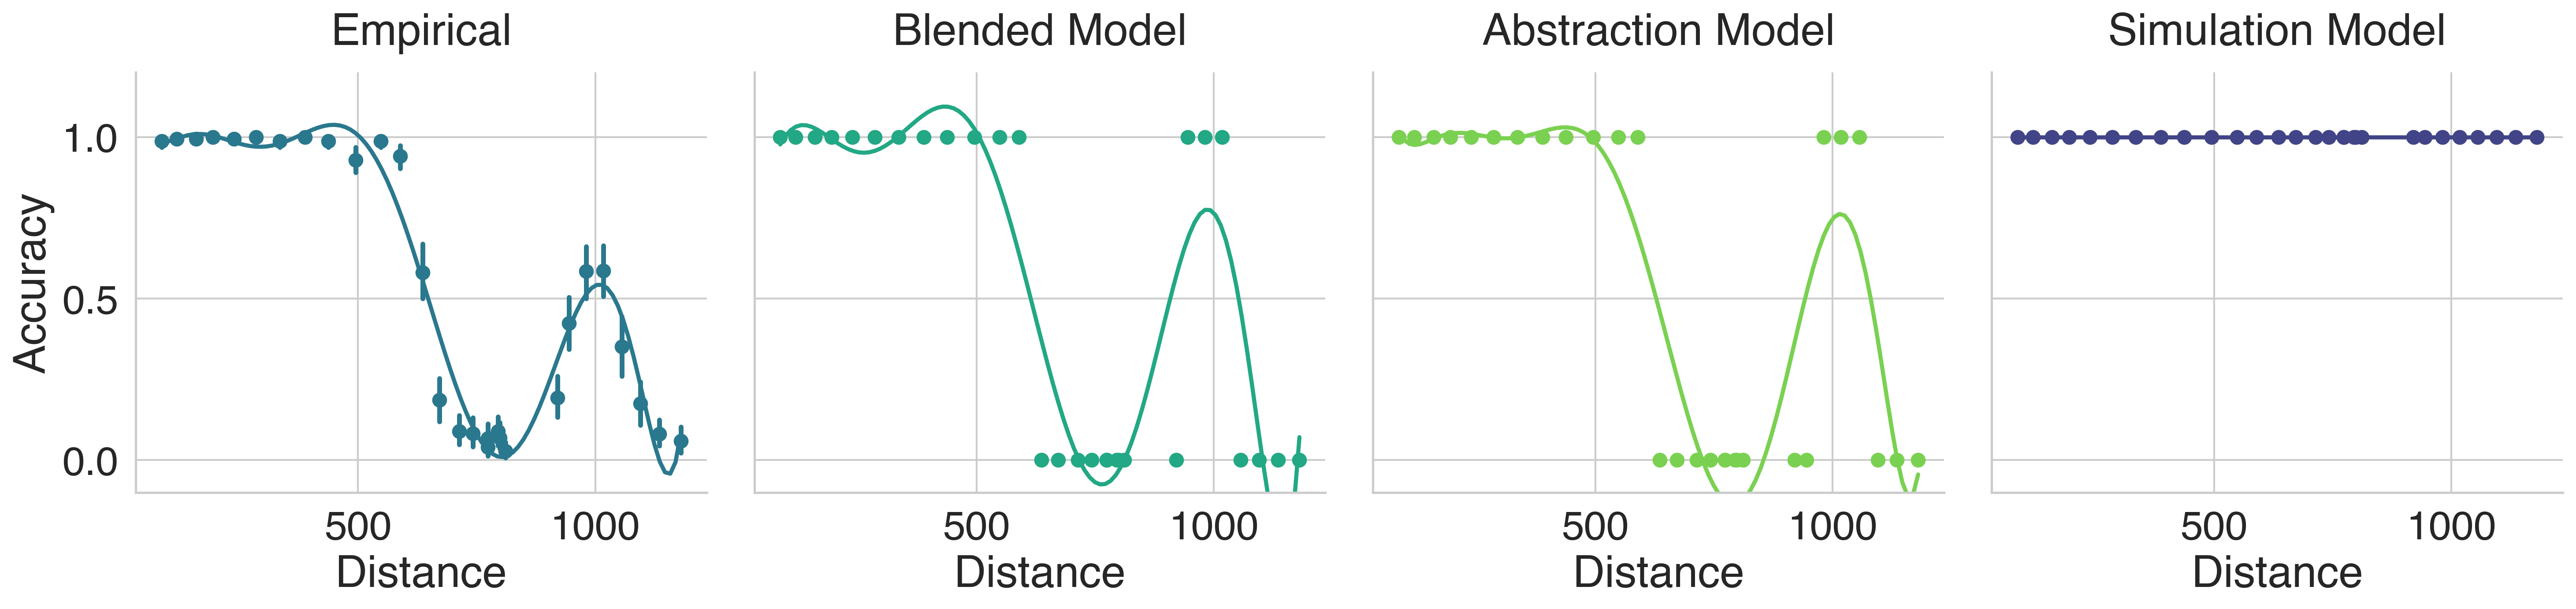

In [227]:
ax = sns.lmplot(
    data=accuracy_df[accuracy_df.scene_type =='1'],
    x="distance",
    y="correct",
    hue='model',
    order=8,
    col='model',
    col_order=[
        'empirical',
        'blended',
        'abstraction',
        'simulation',
    ],
    y_jitter=.01,
    palette='viridis',
    ci=None,
    x_ci=95,
    x_estimator=np.mean
)
ax.set(ylim=(-0.1,1.2))
axes = ax.axes.flatten()
axes[0].set_title('Empirical',pad=15)
axes[1].set_title('Blended Model', pad=15)
axes[2].set_title('Abstraction Model', pad=15)
axes[3].set_title('Simulation Model', pad=15)
ax.set_axis_labels(x_var='Distance', y_var='Accuracy')

if True:
    plt.savefig(f'{figure_dir}/exp2_results_panel.pdf')

,scene,correct,model,goal_point_idx,scene_type,distance
1,scene_1_0,0.987179,empirical,0,1,86.161887
5,scene_1_1,0.993506,empirical,1,1,118.275966
9,scene_1_10,0.987013,empirical,10,1,548.356511
13,scene_1_11,0.941176,empirical,11,1,589.348950
17,scene_1_12,0.580645,empirical,12,1,636.205428
21,scene_1_13,0.186567,empirical,13,1,671.830847
25,scene_1_14,0.089655,empirical,14,1,713.591245
29,scene_1_15,0.082759,empirical,15,1,742.187314
33,scene_1_16,0.039735,empirical,16,1,773.570753
37,scene_1_17,0.027397,empirical,17,1,811.300490


In [64]:
empirical_acc = df_exp2[['correct','scene']]
empirical_acc['model'] = 'empirical'

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_12437/735060496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empirical_acc['model'] = 'empirical'


In [65]:
empirical_acc

,correct,scene,model
34,True,scene_2_6,empirical
44,True,scene_2_20,empirical
59,True,scene_1_3,empirical
64,True,scene_2_7,empirical
74,True,scene_1_12,empirical
...,...,...,...
48054,True,scene_2_13,empirical
48059,False,scene_1_13,empirical
48064,True,scene_2_26,empirical
48069,True,scene_2_5,empirical
